In [29]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
class MyDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.train = train
        if self.train:
            self.data = pd.read_csv("csvTrainImages 13440x1024.csv")
            self.lb = pd.read_csv("csvTrainLabel 13440x1.csv")
            
        else:
            self.data = pd.read_csv("csvTestImages 3360x1024.csv")
            self.lb = pd.read_csv("csvTestLabel 3360x1.csv")

    def __len__(self):
        self.im = self.data.to_numpy().reshape(-1, 1, 32, 32)
        return self.im.shape[0]
    
    def __getitem__(self, idx):
        self.image = self.data.to_numpy().reshape(-1, 1, 32, 32)
        self.label = self.lb.to_numpy().reshape(-1)-1
        return (self.image[idx, :, :, :], self.label[idx])

In [31]:
train_dataset = MyDataset(train=True)
test_dataset = MyDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [32]:
tl = iter(train_loader)
batch_ = next(tl)

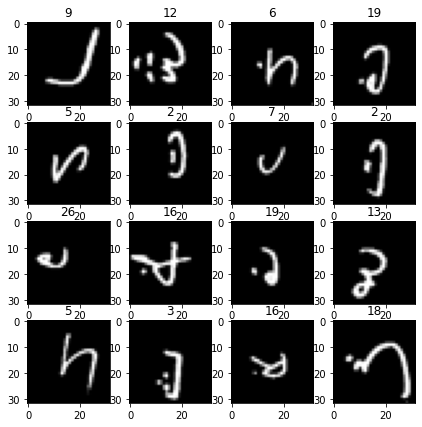

In [33]:
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(batch_[0][i, 0, :, :], cmap='gray')
    plt.title(batch_[1][i].item())
plt.show()

In [34]:
device = torch.device("cuda")

In [35]:
net = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)

In [36]:
for params in net.parameters():
    params.requires_grad=False

In [37]:
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=2048, out_features=28, bias=True)

In [38]:
start = time.time()
net = net.to(device)
num_epochs = 75

lr = 0.05

opt = optim.Adam(params=net.parameters(), lr=lr)
sch = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9)

ls = []

for i in range(num_epochs):
    total_loss = 0
    e_start = time.time()
    for batch in train_loader:
        X, y = batch[0].type(torch.FloatTensor).to(device), batch[1].to(device)
        logits = net(X)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss+=loss.item()
    sch.step()
    ls.append(total_loss)
    if ((i+1)%20 == 0) or (i == 0):
        print(f"For Epoch: {i+1}/{num_epochs}:\nLoss = {ls[i]}\nTime = {(time.time() - e_start):.2f} seconds\t{num_epochs-(i+1)} Epochs To go...")
        print("-"*25)
print("_"*50)
print(f"\nTraining done in {((time.time() - start)/60):.2f} Minutes\n with loss {ls[-1]}\n")
print("_"*50)

For Epoch: 1/75:
Loss = 4469.788673400879
Time = 5.67 seconds	74 Epochs To go...
-------------------------
For Epoch: 20/75:
Loss = 762.141068816185
Time = 5.61 seconds	55 Epochs To go...
-------------------------
For Epoch: 40/75:
Loss = 382.8766869902611
Time = 5.63 seconds	35 Epochs To go...
-------------------------
For Epoch: 60/75:
Loss = 331.58261781930923
Time = 5.63 seconds	15 Epochs To go...
-------------------------
__________________________________________________

Training done in 7.10 Minutes
 with loss 324.0177257657051

__________________________________________________


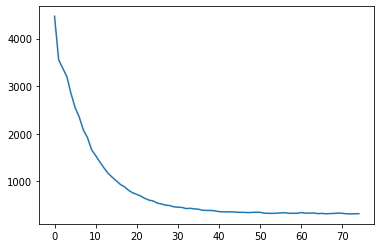

In [39]:
plt.plot(ls);

In [40]:
for params in net.parameters():
    params.requires_grad=True

In [41]:
start = time.time()
num_epochs = 50

lr = 1e-3

opt = optim.Adam(params=net.parameters(), lr=lr)
sch = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9)

ls = []

for i in range(num_epochs):
    total_loss = 0
    e_start = time.time()
    for batch in train_loader:
        X, y = batch[0].type(torch.FloatTensor).to(device), batch[1].to(device)
        logits = net(X)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss+=loss.item()
    sch.step()
    ls.append(total_loss)
    if ((i+1)%10 == 0):
        print(f"For Epoch: {i+1}/{num_epochs}:\nLoss = {ls[i]}\nTime = {(time.time() - e_start):.2f} seconds\t{num_epochs-(i+1)} To go...")
        print("-"*50)
print("_"*50)
print(f"\nTraining Done in {((time.time() - start)/60):.2f} Minutes\n with loss {ls[-1]}\n")
print("_"*50)

For Epoch: 10/50:
Loss = 36.65757964737713
Time = 9.35 seconds	40 To go...
--------------------------------------------------
For Epoch: 20/50:
Loss = 9.653036869189236
Time = 9.33 seconds	30 To go...
--------------------------------------------------
For Epoch: 30/50:
Loss = 1.874659286782844
Time = 9.26 seconds	20 To go...
--------------------------------------------------
For Epoch: 40/50:
Loss = 0.4910692036501132
Time = 9.32 seconds	10 To go...
--------------------------------------------------
For Epoch: 50/50:
Loss = 0.2059540137224758
Time = 9.37 seconds	0 To go...
--------------------------------------------------
__________________________________________________

Training Done in 7.78 Minutes
 with loss 0.2059540137224758

__________________________________________________


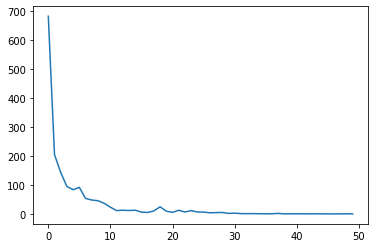

In [42]:
plt.plot(ls);

In [43]:
net.eval()
@torch.no_grad()
def test_accuracy(net, test_loader):
  average_acc = 0
  for batch in test_loader:
    X, y = batch[0].type(torch.FloatTensor).to(device),  batch[1].to(device)
    logits = net(X)
    labels = torch.argmax(logits, axis = 1)
    acc = torch.sum(labels == y, axis =0)/y.shape[0]
    average_acc+=acc

  print(average_acc/ len(test_loader))

test_accuracy(net, test_loader)

tensor(0.9475, device='cuda:0')
